In [1]:
import json

In [2]:
review_coll = json.load(open("reviews.json","r"))

In [3]:
len(review_coll)

1128

In [4]:
import pandas as pd
review_df = pd.DataFrame(review_coll)

In [5]:
review_df.shape

(1128, 8)

In [6]:
review_df.columns

Index([u'author', u'body', u'colour', u'date', u'header', u'rating', u'size',
       u'verified_purchase'],
      dtype='object')

### Analysis on non-text

#### 1. Author

In [7]:
sec_df = review_df[["author","rating"]]

In [8]:
sec_df.shape

(1128, 2)

In [9]:
author_df = sec_df.groupby(["author"])["rating"].count().reset_index()

In [10]:
author_df[author_df["rating"]>1].shape # Discard Author Dimension

(26, 2)

#### 2. Colour

In [11]:
sec_df = review_df[["colour","rating"]].dropna()

In [12]:
sec_df.shape

(916, 2)

In [13]:
sec_df.groupby(["colour","rating"])["rating"].count()

colour      rating
silver      1.0        58
            2.0        14
            3.0        13
            4.0        51
            5.0       336
space grey  1.0        60
            2.0         8
            3.0        19
            4.0        38
            5.0       319
Name: rating, dtype: int64

#### 3. Size

In [14]:
sec_df = review_df[["size","rating"]].dropna()

In [15]:
sec_df.shape

(916, 2)

In [16]:
sec_df.groupby(["size","rating"])["rating"].count() # Discard

size   rating
256gb  1.0        13
       2.0         2
       3.0         2
       4.0        10
       5.0        71
64gb   1.0       105
       2.0        20
       3.0        30
       4.0        79
       5.0       584
Name: rating, dtype: int64

#### 4. verified_purchase

In [17]:
sec_df = review_df[["verified_purchase","rating"]].dropna()

In [18]:
sec_df.shape

(1128, 2)

In [19]:
sec_df.groupby(["verified_purchase","rating"])["rating"].count() # Discard

verified_purchase  rating
False              1.0        64
                   2.0        12
                   3.0        16
                   4.0        29
                   5.0       163
True               1.0        94
                   2.0        16
                   3.0        28
                   4.0        75
                   5.0       631
Name: rating, dtype: int64

#### 5. Date

In [20]:
sec_df = review_df[["date","rating"]]

In [21]:
sec_df["conv_date"]=pd.to_datetime(sec_df["date"],format = "%d %B %Y")

/Users/sharmili/miniconda2/envs/playground/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
sec_df.columns

Index([u'date', u'rating', u'conv_date'], dtype='object')

In [23]:
sec_df["month"] = sec_df.apply(lambda x: x["conv_date"].month,axis=1)

/Users/sharmili/miniconda2/envs/playground/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


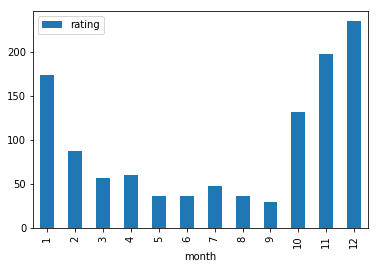

In [24]:
%matplotlib inline
sec_df.pivot_table(index='month', values='rating', aggfunc=len).plot(kind='bar')

# Sentiment model

### Train - Validation - Test split

In [35]:
data_df = review_df[["body","header","rating"]]

In [45]:
data_df.shape

(1128, 3)

In [46]:
from sklearn.model_selection import train_test_split
train_val_df, test_df = train_test_split(data_df, test_size=0.2)

In [47]:
train_df, val_df = train_test_split(train_val_df, test_size=0.25)

In [48]:
len(train_df)

676

In [49]:
len(val_df)

226

In [50]:
len(test_df)

226

### Cleaning Pipeline

In [51]:
# 1. Lowercase
# 2. Remove numbers and special characters
# 3. Remove stop words
# 4. Stemming

In [52]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

ps = PorterStemmer()
def clean(text):
    if not text:
        return ""
    text = text.lower()
    text = re.sub(r'[^A-Za-z]+', ' ', text)
    word_tokens = word_tokenize(text)
    filtered_sentence = list([ps.stem(w) for w in word_tokens if (not w in stop_words and len(w)>1)])
    return " ".join(filtered_sentence)

ValueError: unknown locale: UTF-8

### Vectorisor 

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [54]:
vectorizer = TfidfVectorizer()

### Model

In [55]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

### Pipeline

In [57]:
def train_pipeline(data_df, vectorizer_, model_):
    data_df["cleaned_text"] = data_df.apply(lambda x: clean(x["text"]),axis=1)
    features_ = vectorizer_.fit_transform(data_df["cleaned_text"])
    model_.fit(features_)
    return vectorizer_, model_, features_

In [58]:
def test_pipeline(data_df, vectorizer_, model_):
    data_df["cleaned_text"] = data_df.apply(lambda x: clean(x["text"]),axis=1)
    features = vectorizer_.transform(data_df["cleaned_text"])
    model_.predict(features)

### Accuracy Evaluation

In [59]:
from sklearn.metrics import accuracy_score
def get_accuracy(actual_vals_, predicted_vals_):
    return accuracy_score(actual_vals_, predicted_vals_)